In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Record the start time
start_time = time.time()

# Step 1: Load and Explore Data
train_data = pd.read_csv("/Users/tejalpatel/Desktop/sf-crime/train.csv")

# Record the end time
end_time = time.time()

# Calculate the time taken
loading_time = end_time - start_time

# Print the loading time
print(f"Time taken for loading data: {loading_time} seconds")

Time taken for loading data: 1.0136640071868896 seconds


In [3]:
# Step 1: Load and Explore Data
train_data = pd.read_csv("/Users/tejalpatel/Desktop/sf-crime/train.csv")
train_data

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541
...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607


In [4]:
# Step 2: Text Preprocessing
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenization and removal of stop words
    tokens = text.split()
    tokens = [ps.stem(word) for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

train_data['preprocessed_text'] = train_data['Descript'].apply(preprocess_text)


In [5]:
# Step 3: Word Embeddings (Word2Vec)
corpus = train_data['preprocessed_text'].apply(lambda x: x.split())
word2vec_model = Word2Vec(corpus, vector_size=100, window=5, min_count=1, workers=4)

In [6]:
# Step 4: Feature Extraction
def get_average_vector(words, model):
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if not word_vectors:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

train_data['word2vec_features'] = train_data['preprocessed_text'].apply(lambda x: get_average_vector(x.split(), word2vec_model))

In [7]:
# Features and target variable
X = list(train_data['word2vec_features'])
y = train_data['Category']

In [8]:
# Step 5: Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Step 6: Logistic Regression Model
logistic_model = LogisticRegression(max_iter=100)


In [10]:
# Step 7: Hyperparameter Tuning with GridSearchCV
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(logistic_model, parameters, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy', n_jobs=-1)
start_time_gridsearch = time.time()
grid_search.fit(X_train, y_train)
end_time_gridsearch = time.time()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/st

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [11]:
# Print best parameters from grid search
print("Best Parameters: ", grid_search.best_params_)


Best Parameters:  {'C': 100}


In [12]:
# Calculate and print execution time for GridSearchCV
execution_time_gridsearch = end_time_gridsearch - start_time_gridsearch
print(f"GridSearchCV Execution Time: {execution_time_gridsearch} seconds")

GridSearchCV Execution Time: 887.5055072307587 seconds


In [13]:
# Step 8: Model Evaluation on Test Set
best_logistic_model = grid_search.best_estimator_
y_pred = best_logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9952451454928535


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                             precision    recall  f1-score   support

                      ARSON       1.00      1.00      1.00       321
                    ASSAULT       1.00      1.00      1.00     15364
                 BAD CHECKS       1.00      1.00      1.00        72
                    BRIBERY       0.97      1.00      0.98        58
                   BURGLARY       1.00      1.00      1.00      7389
         DISORDERLY CONDUCT       1.00      1.00      1.00       828
DRIVING UNDER THE INFLUENCE       1.00      1.00      1.00       459
              DRUG/NARCOTIC       1.00      1.00      1.00     10723
                DRUNKENNESS       1.00      1.00      1.00       857
               EMBEZZLEMENT       1.00      1.00      1.00       222
                  EXTORTION       1.00      1.00      1.00        51
            FAMILY OFFENSES       0.93      1.00      0.96        92
     FORGERY/COUNTERFEITING       1.00      1.00      1.00      2092
                      FRAUD      

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  321     0     0 ...     0     0     0]
 [    0 15301     0 ...     0     0     2]
 [    0     0    72 ...     0     0     0]
 ...
 [    0     0     0 ... 10304     0     0]
 [    0     0     0 ...     0  8514     0]
 [    0     8     0 ...     0     0  1699]]


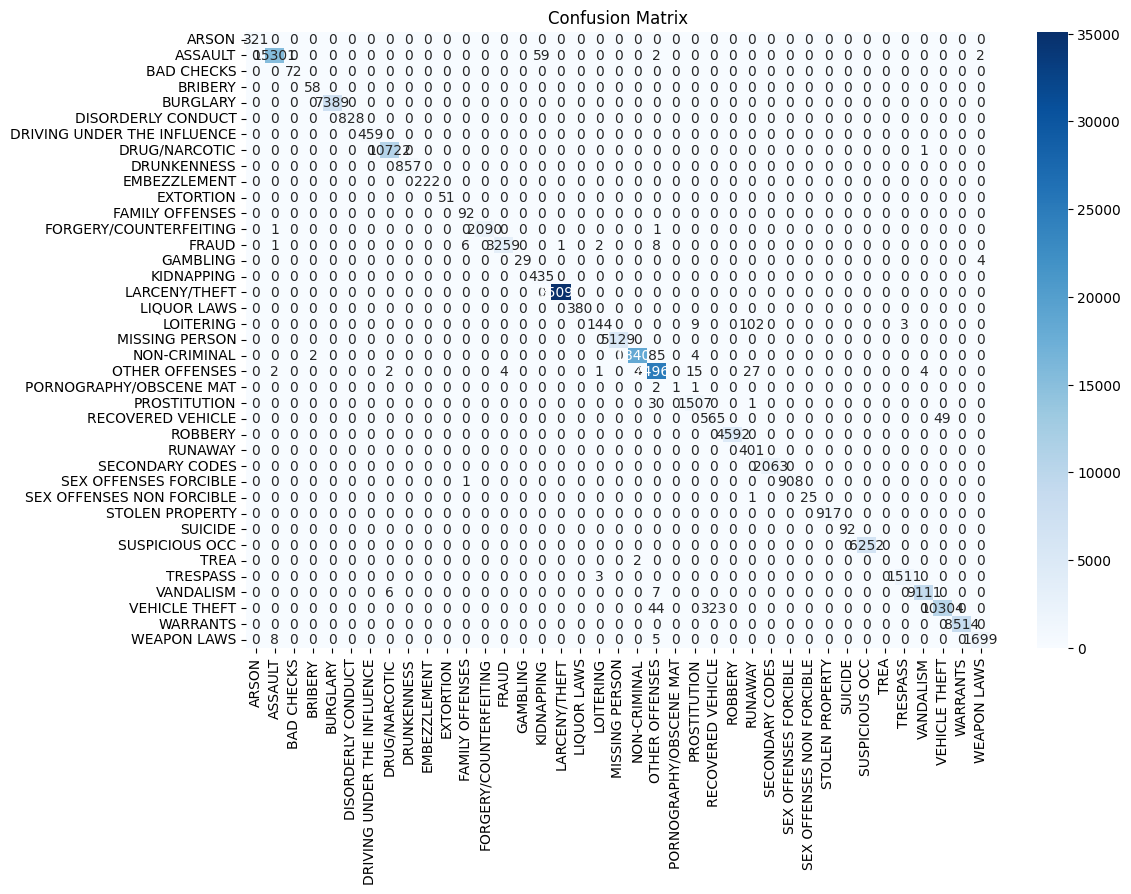

In [15]:
# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=best_logistic_model.classes_, yticklabels=best_logistic_model.classes_)
plt.title("Confusion Matrix")
plt.show()

In [16]:
# Print execution time for grid search
execution_time_gridsearch = end_time_gridsearch - start_time_gridsearch
print(f"GridSearchCV Execution Time: {execution_time_gridsearch} seconds")


GridSearchCV Execution Time: 887.5055072307587 seconds


In [17]:
# Step 9: Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
start_time_crossval = time.time()
cross_val_results = cross_val_score(best_logistic_model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
end_time_crossval = time.time()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [18]:
# Print cross-validation results
print(f"Cross-Validation Accuracy: {np.mean(cross_val_results)}")
print(f"Cross-Validation Accuracy Scores: {cross_val_results}")

Cross-Validation Accuracy: 0.9952018613352227
Cross-Validation Accuracy Scores: [0.9946814  0.99605376 0.99563237 0.9952964  0.99434539]


In [19]:
# Print execution time for cross-validation
execution_time_crossval = end_time_crossval - start_time_crossval
print(f"Cross-Validation Execution Time: {execution_time_crossval} seconds")

Cross-Validation Execution Time: 161.7260069847107 seconds


In [20]:
# Step 10: Final Logistic Regression Model
final_logistic_model = LogisticRegression(max_iter=100)
start_time_lr = time.time()
final_logistic_model.fit(X_train, y_train)
end_time_lr = time.time()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
# Step 11: Model Evaluation
y_pred_lr = final_logistic_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy (Final LR Model): {accuracy_lr}")
print(classification_report(y_test, y_pred_lr))

Accuracy (Final LR Model): 0.9945447297989863


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                             precision    recall  f1-score   support

                      ARSON       1.00      1.00      1.00       321
                    ASSAULT       1.00      0.98      0.99     15364
                 BAD CHECKS       1.00      1.00      1.00        72
                    BRIBERY       1.00      0.93      0.96        58
                   BURGLARY       1.00      1.00      1.00      7389
         DISORDERLY CONDUCT       1.00      1.00      1.00       828
DRIVING UNDER THE INFLUENCE       1.00      1.00      1.00       459
              DRUG/NARCOTIC       1.00      1.00      1.00     10723
                DRUNKENNESS       1.00      1.00      1.00       857
               EMBEZZLEMENT       1.00      1.00      1.00       222
                  EXTORTION       1.00      1.00      1.00        51
            FAMILY OFFENSES       0.94      1.00      0.97        92
     FORGERY/COUNTERFEITING       1.00      1.00      1.00      2092
                      FRAUD      

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


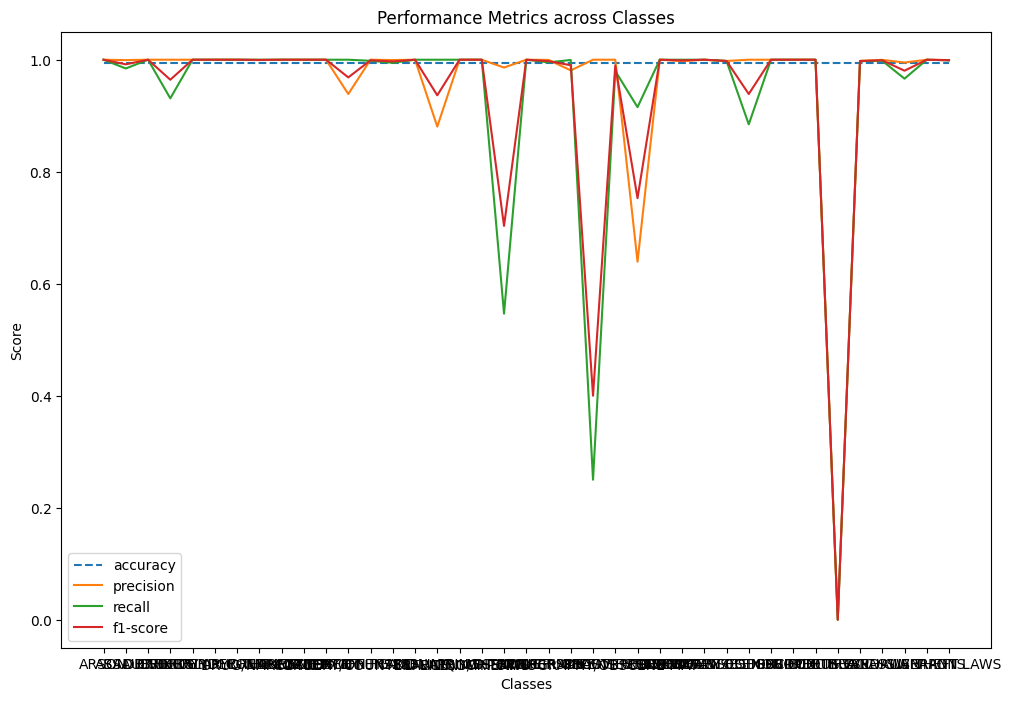

In [22]:
report_lr = classification_report(y_test, y_pred_lr, output_dict=True)

# Plotting line graph for accuracy, precision, recall, and F1-score
classes = list(final_logistic_model.classes_)
metrics = ['precision', 'recall', 'f1-score']

# Extract accuracy separately
accuracy = [accuracy_lr] * len(classes)

plt.figure(figsize=(12, 8))

# Plot accuracy
plt.plot(classes, accuracy, label='accuracy', linestyle='--')

# Plot precision, recall, and F1-score
for metric in metrics:
    values = [report_lr[class_][metric] for class_ in classes]
    plt.plot(classes, values, label=metric)

plt.title("Performance Metrics across Classes")
plt.xlabel("Classes")
plt.ylabel("Score")
plt.legend()
plt.show()

In [23]:
# Print confusion matrix for the final model
conf_matrix_final = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix (Final Model):")
print(conf_matrix_final)

Confusion Matrix (Final Model):
[[  321     0     0 ...     0     0     0]
 [    0 15124     0 ...     0     0     0]
 [    0     0    72 ...     0     0     0]
 ...
 [    0     0     0 ... 10310     0     0]
 [    0     0     0 ...     0  8514     0]
 [    0     2     0 ...     0     0  1710]]


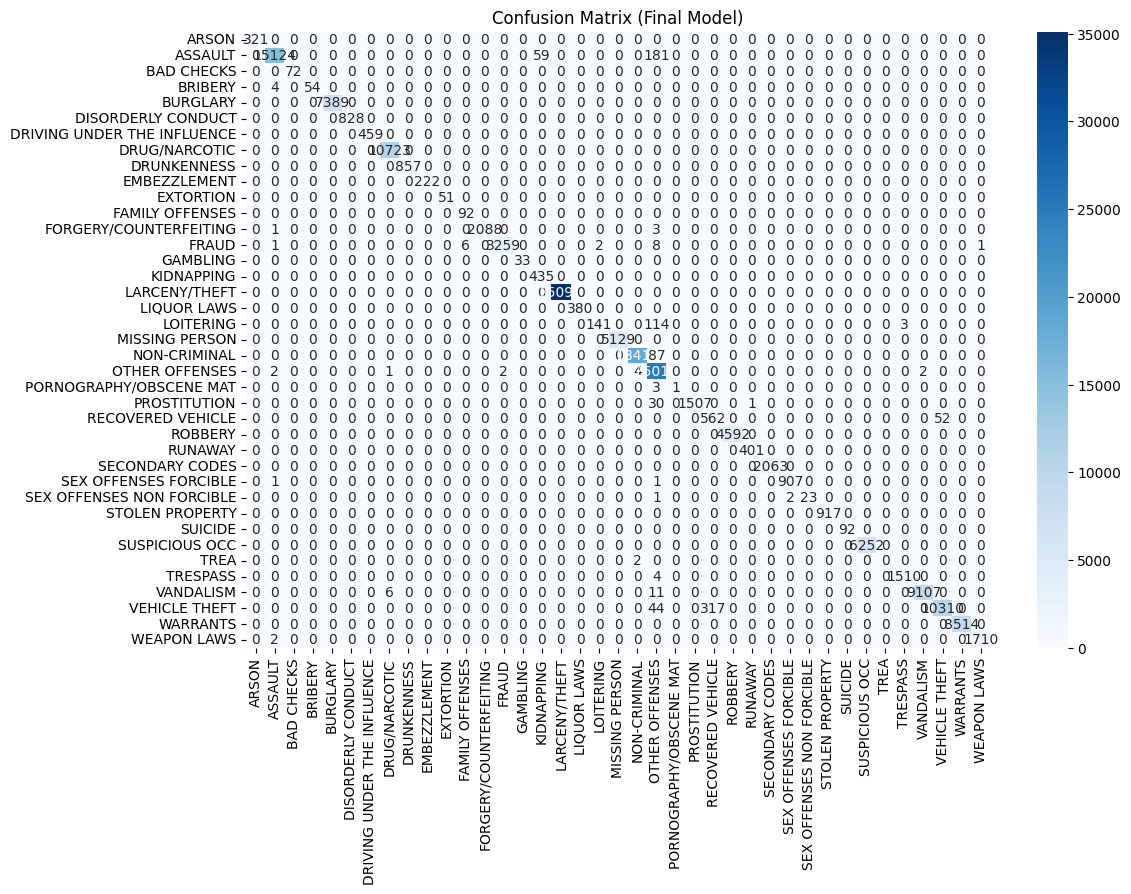

In [24]:
# Plot confusion matrix for the final model
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_final, annot=True, fmt="d", cmap="Blues", xticklabels=final_logistic_model.classes_, yticklabels=final_logistic_model.classes_)
plt.title("Confusion Matrix (Final Model)")
plt.show()

In [25]:
# Print execution time for the final LR model
execution_time_lr = end_time_lr - start_time_lr
print(f"Final LR Model Execution Time: {execution_time_lr} seconds")

Final LR Model Execution Time: 282.0471160411835 seconds


Total Execution Time: 3496.3 seconds


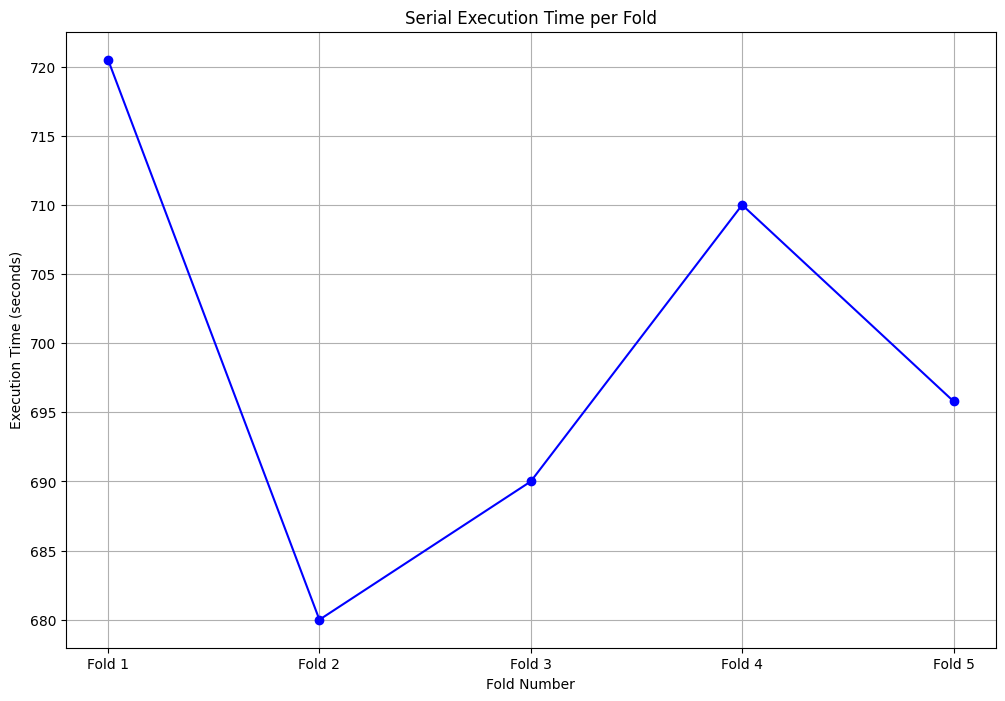

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate total execution time
total_execution_time = np.sum(execution_times_per_fold)

# Print the total execution time
print(f"Total Execution Time: {total_execution_time} seconds")

# Labels for the plot
labels = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']

# Plot the execution times per fold
plt.figure(figsize=(12, 8))
plt.plot(labels, execution_times_per_fold, marker='o', linestyle='-', color='b')
plt.title("Serial Execution Time per Fold")
plt.xlabel("Fold Number")
plt.ylabel("Execution Time (seconds)")
plt.grid(True)
plt.show()


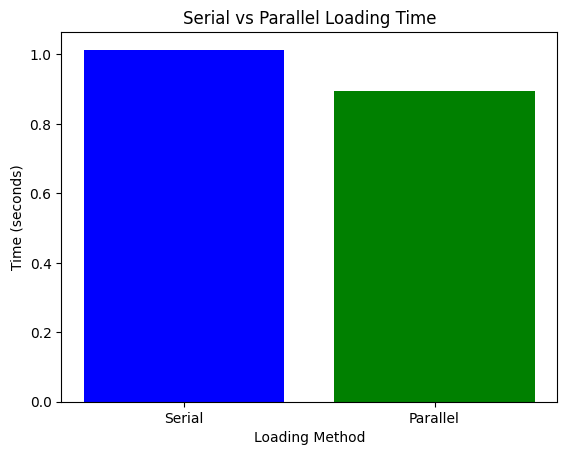

In [34]:
import matplotlib.pyplot as plt

# Timing data
serial_time = 1.0136640071868896
parallel_time = 0.8943850994110107

# Plotting
labels = ['Serial', 'Parallel']
times = [serial_time, parallel_time]

plt.bar(labels, times, color=['blue', 'green'])
plt.title('Serial vs Parallel Loading Time')
plt.xlabel('Loading Method')
plt.ylabel('Time (seconds)')
plt.show()
